In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting Started with Archetypal Analysis

Archetypal Analysis (AA) is a matrix factorization technique that identifies "pure types" or archetypes within your data. Unlike other dimensionality reduction methods, AA finds extreme points that represent the corners of the convex hull containing your data points.

## What is Archetypal Analysis?

Archetypal Analysis discovers a set of archetypes that are:
- **Convex combinations** of the original data points (archetypes are mixtures of real observations)
- **Extreme points** that define the boundaries of your data space
- **Interpretable** representations of the "purest" forms in your dataset

Each data point is then expressed as a convex combination (weighted mixture) of these archetypes, with weights that sum to 1.

## Loading Data

Let's start with the classic Iris dataset to demonstrate the basics:

In [178]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features: sepal length/width, petal length/width
feature_names = iris.feature_names
print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## The AA Class

The `AA` class is the main interface for performing Archetypal Analysis. It is designed to be fully compatible with `scikit-learn`, making it easy to integrate into existing machine learning pipelines.

Let's explore its key parameters:

In [179]:
from archetypes import AA

# Initialize the AA model
model = AA(
    n_archetypes=3,  # Number of archetypes to find
    max_iter=1000,  # Maximum number of iterations
    method="pgd",  # Optimization method (Projected Gradient Descent)
    init="uniform",  # Archetype initialization method
    tol=1e-4,  # Tolerance for convergence
    verbose=False,  # Print progress messages
    random_state=42,  # For reproducible results
)

print("Model initialized with parameters:")
print(model.get_params())

Model initialized with parameters:
{'init': 'uniform', 'init_kwargs': None, 'max_iter': 1000, 'method': 'pgd', 'method_kwargs': None, 'n_archetypes': 3, 'n_init': 1, 'random_state': 42, 'save_init': False, 'tol': 0.0001, 'verbose': False}


## Training the Model

Training is straightforward with the `fit` method:

In [180]:
# Fit the model to our data
_ = model.fit(X)

print("Model training completed!")

Model training completed!


## Monitoring Training Progress

Let's visualize how the model's loss (reconstruction error) decreased during training:

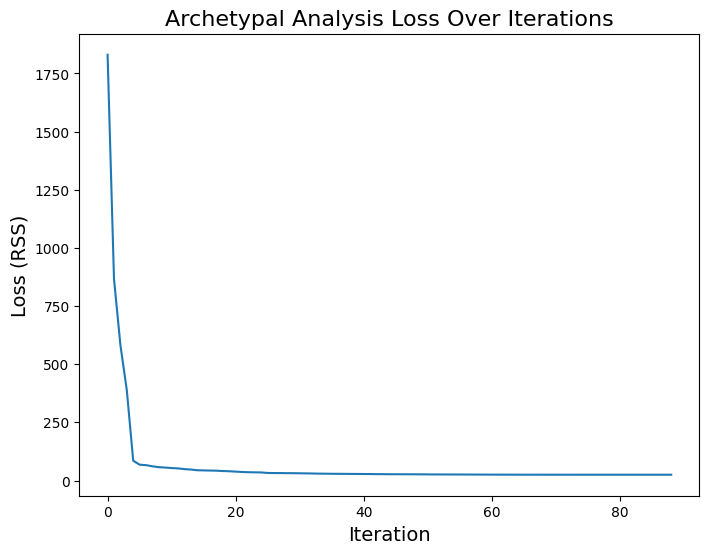

In [181]:
import matplotlib.pyplot as plt

# Visualize the loss over iterations of the fitting process

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(model.loss_)

ax.set_title("Archetypal Analysis Loss Over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Loss (RSS)", fontsize=14)

plt.show()

## Understanding the Results

After training, the model provides several important attributes:

### 1. Archetypes

The archetypes we discovered can be thought of as the “corner points” of the data. In the Iris dataset, these archetypes represent flowers with very extreme characteristics.
Below, we project both the original data and the learned archetypes into two dimensions using PCA, and then plot them.
This visualization helps you:
- See where the archetypes are located relative to the main cloud of data (often close to the boundary).
- Understand how each data point can be expressed as a mixture of these archetypes.

Important notes and suggestions:
- PCA is used only for visualization: the 2D projection may distort distances and angles from the original feature space. An archetype that looks interior in 2D can still be extreme in higher dimensions.

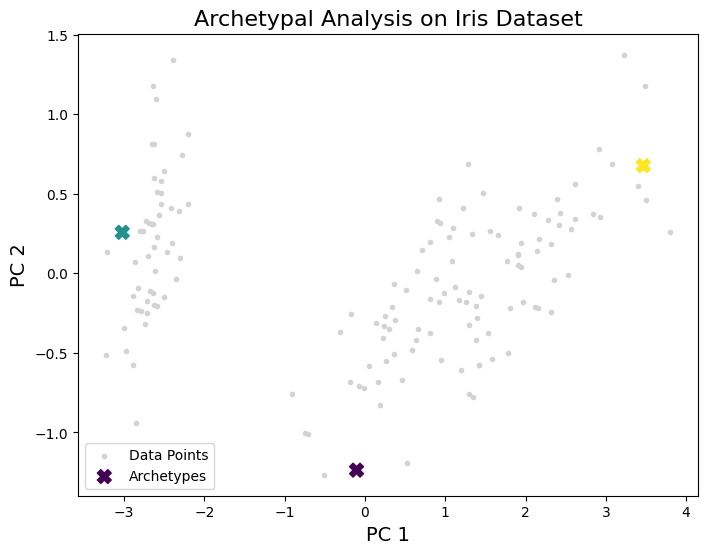

In [182]:
from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
archetypes_2d = pca.transform(model.archetypes_)

# Plot data points and archetypes
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgrey", marker=".", label="Data Points")
ax.scatter(
    archetypes_2d[:, 0],
    archetypes_2d[:, 1],
    c=range(model.n_archetypes),
    marker="X",
    s=100,
    label="Archetypes",
)

ax.set_title("Archetypal Analysis on Iris Dataset", fontsize=16)
ax.set_xlabel("PC 1", fontsize=14)
ax.set_ylabel("PC 2", fontsize=14)

ax.legend()

plt.show()

The plot demonstrates how Archetypal Analysis successfully identifies extreme "pure types" within the Iris dataset. The red X markers represent the 3 discovered archetypes, which are positioned at the boundary corners of the data distribution rather than at cluster centers like K-means would produce. These archetypes define the convex hull (triangular boundary) that encompasses all 150 gray data points in the 2D PCA-reduced space.

This visualization reveals AA's key insight: every flower in the dataset can be expressed as a weighted mixture of these three extreme archetypal forms. Unlike traditional clustering methods that find dense regions, Archetypal Analysis identifies the "purest" specimens that represent the most distinctive combinations of features, making it particularly valuable for understanding the fundamental patterns and boundaries within biological datasets like iris flower measurements.


### 2. Similarity Degrees

The most important output of the model is the **similarity degrees**.
These values show how each observation can be represented as a **convex combination of the archetypes**.  
In other words, they can be seen as a projection of the data into the **archetypal space**, i.e., into a **simplex**.

In [183]:
similarity_degrees = model.similarity_degree_

# Show composition of first few flowers
print("\nFirst 5 flowers' archetype compositions:")
for i in range(5):
    composition = similarity_degrees[i]
    print(f"Flower {i+1}: {composition}")


First 5 flowers' archetype compositions:
Flower 1: [0.         0.94732765 0.05267235]
Flower 2: [0.14395919 0.85604081 0.        ]
Flower 3: [0.09239078 0.90760922 0.        ]
Flower 4: [0.15595389 0.84404611 0.        ]
Flower 5: [0.         0.95429922 0.04570078]


These results tell us how much each of the first five flowers resembles the three archetypes we found. The numbers can be read like “percentages of similarity” with each archetype.

- **Flower 1** → almost exactly like Archetype 2 (95%), with just a tiny bit of Archetype 3.  
- **Flowers 2, 3, and 4** → also very close to Archetype 2, but each one mixes in a small part of Archetype 1.  
- **Flower 5** → almost a copy of Archetype 2, with a little bit of Archetype 3.  

👉 In simple terms: the first five flowers are all strongly related to Archetype 2, which means they share very similar features (like petal length and width) with that group of flowers.  
Archetypes 1 and 3 only play a minor role here.

however, a more visual way to explore these relationships is by using a **simplex plot**, which represents each observation as a point inside a triangle (or higher-dimensional simplex) where the corners correspond to the archetypes.


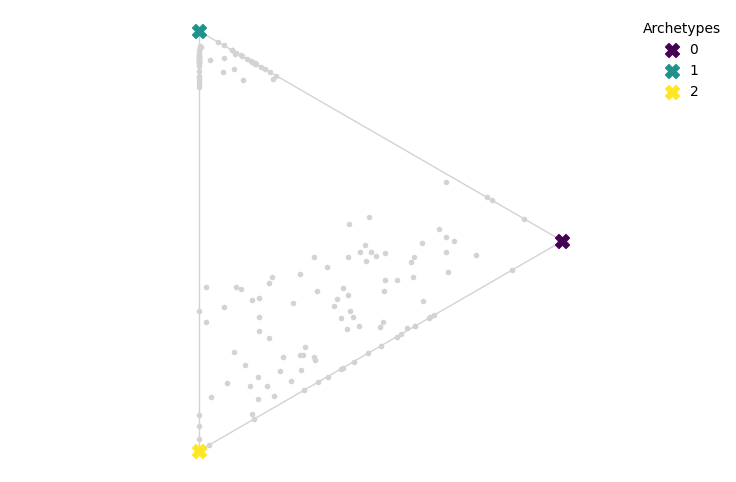

In [184]:
from archetypes.visualization import simplex

fig, ax = plt.subplots(figsize=(8, 6))

simplex(
    similarity_degrees,
    marker=".",
    show_vertices=True,
    vertices_size=100,
    vertice_marker="X",
    vertices_color=range(model.n_archetypes),
)

plt.show()

As said, a **simplex plot** shows how each observation is represented as a mixture of the archetypes:

- Each **corner** of the simplex corresponds to one archetype (the extreme points).  
- Each **point inside the simplex** represents a single observation, positioned according to how much it resembles each archetype.  
- Points **close to a corner** are very similar to that archetype, meaning they are mostly explained by it.  
- Points **near the center or edges** are combinations of two or more archetypes.  

In other words, this simplex plot provides a **geometric visualization** of how the data is expressed in terms of the archetypes, allowing us to quickly see which observations are strongly aligned with a single archetype and which are mixtures.


### 3. Archetypes Similarity Degrees

Finally, the archetypes similarity degrees indicate how each archetype is composed of the original data points. This can help you understand which specific observations are most representative of each archetype.

In [185]:
import numpy as np

archetypes_similarity_degrees = model.archetypes_similarity_degree_

# Show composition of each archetype
print("\nArchetypes' compositions in terms of original data points:")
for k in range(model.n_archetypes):
    composition = archetypes_similarity_degrees[k].nonzero()[0]
    print(f"Archetype {k+1}: {composition}")


Archetypes' compositions in terms of original data points:
Archetype 1: [ 60 106]
Archetype 2: [13 14 22]
Archetype 3: [109 117 118]


Now we look at how each archetype is constructed from specific flowers in the dataset.  
These flowers serve as the building blocks for the extreme points (the archetypes):

- **Archetype 1** → formed from flowers #60 and #106.  
- **Archetype 2** → formed from flowers #13, #14, and #22.  
- **Archetype 3** → formed from flowers #109, #117, and #118.  

👉 In other words, each archetype —as an extreme representation of the data— is defined as a combination of a few actual flowers from the dataset.  
All other flowers can then be expressed as mixtures of these archetypes.

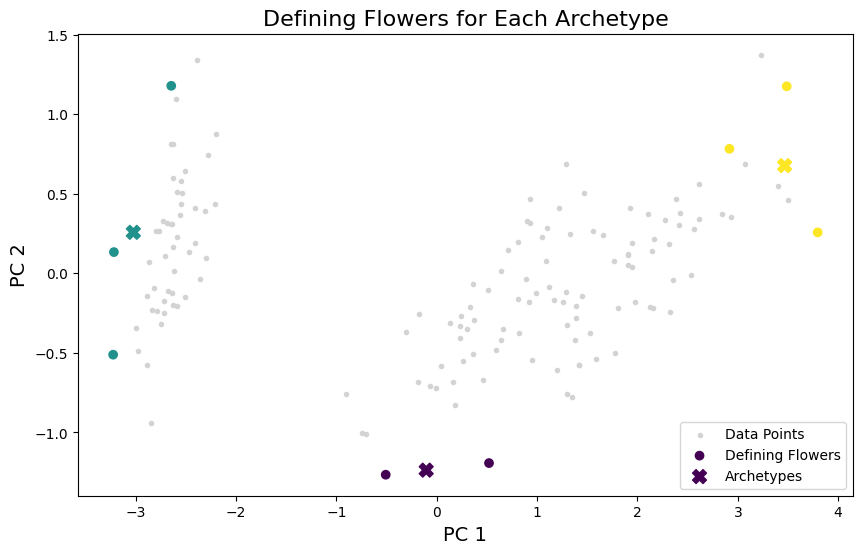

In [186]:
c, flowers = archetypes_similarity_degrees.nonzero()
flowers_2d = pca.transform(X[flowers])

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgrey", marker=".", label="Data Points")
ax.scatter(flowers_2d[:, 0], flowers_2d[:, 1], c=c, marker="o", label="Defining Flowers")
ax.scatter(
    archetypes_2d[:, 0],
    archetypes_2d[:, 1],
    c=range(model.n_archetypes),
    marker="X",
    s=100,
    label="Archetypes",
)

ax.set_title("Defining Flowers for Each Archetype", fontsize=16)

ax.set_xlabel("PC 1", fontsize=14)
ax.set_ylabel("PC 2", fontsize=14)

ax.legend()

plt.show()

As we can see in the plot, only a **small number of flowers** from the dataset are used to define the archetypes.  
These few flowers act as the building blocks for the extreme points, and every flower is expressed as a mixture of these archetypes.  

## Key Takeaways

1. **Archetypes are interpretable**: They represent extreme, "pure" types in your data
2. **Every point is a mixture**: Each observation is expressed as a weighted combination of archetypes
3. **Archetypes are defined by few data points**: Each archetype is itself a convex combination of a small subset of the original data

## Next Steps
- Try different numbers of archetypes to find the optimal representation
- Learn about specialized variants like `ADA` or `BiAA`
- Apply AA to your own datasets for domain-specific insights